## Generated figures:
* S3E (relationship between lick COM and velocity deviations across all mice)
* S3F (relationship between lick COM and velocity deviations for individual mice)

We also run the statistical tests needed for these figures.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, linregress, norm

from os import sys
sys.path.append('..')
import data_util
import decoder_util
import plotting_util
import style

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = "none"


FIG_DIR = "../figures/"
DECODER_RESULTS_FILENAME = "../analysis_data/decoder_results_neuron_review.npz"

In [2]:
#Load vel. info from decoder analysis (see 'decoder.ipynb')
results = np.load(DECODER_RESULTS_FILENAME)
avg_vel_mice_days = results["avg_vel"].reshape((5, 6, 50)) 
#Use factor of 1e-2 to convert velocity from cm/s to m/s
avg_vel_mice_days *= 1e-2
avg_vel_deviations_mice_days = avg_vel_mice_days - np.nanmean(avg_vel_mice_days, axis=-1, keepdims=True)
#avg_vel_deviations_days = avg_vel_deviations_mice_days.swapaxes(0, 1).reshape((6, -1))

In [3]:
#Load lick rate data. Takes ~15 s.
lick_rate = data_util.load_all_binned_behavior_data("lick_rate")

#Compute licking COM.
licking_com_mice_days = data_util.compute_licking_com(lick_rate)
#Use factor of 1e-1 to convert from bins to m
licking_com_mice_days *= 1e-1
#Don't want first 2 days (pretraining)
licking_com_mice_days = licking_com_mice_days[:, 2:]

1
2
3
4
5


In [5]:
np.random.seed(42) #note: different seed used in publication figure
num_bootstraps = 10000
linregress_bootstrap_results_mice_days = np.zeros((5, 6, num_bootstraps, 5))
linregress_results_mice_days = np.zeros((5, 6, 5))

for mouse_num in range(1, 6):
    print("mouse", mouse_num)
    for day_num in range(6):
        result = data_util.linregress_bootstrap(avg_vel_deviations_mice_days[mouse_num-1, day_num],
                                                licking_com_mice_days[mouse_num-1, day_num],
                                                num_bootstraps=num_bootstraps)
        linregress_results_mice_days[mouse_num-1, day_num] = result[0]
        linregress_bootstrap_results_mice_days[mouse_num-1, day_num] = result[1]
        
bootstrap_slopes_mice_days = linregress_bootstrap_results_mice_days[:, :, :, 0]

mouse 1
mouse 2
mouse 3
mouse 4
mouse 5


In [6]:
print("Test for slopes significantly greater than zero")
slope_p_vals = np.sum(bootstrap_slopes_mice_days < 0, axis=-1) / num_bootstraps
print(slope_p_vals)

print("\nTest for mouse-average slopes significantly greater than zero")
bootstrap_slopes_days = bootstrap_slopes_mice_days.mean(axis=0)
avg_slope_p_vals = np.sum(bootstrap_slopes_days < 0, axis=-1) / num_bootstraps
print(avg_slope_p_vals)

Test for slopes significantly greater than zero
[[0.000e+00 1.000e-04 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [4.000e-04 6.180e-02 8.400e-03 0.000e+00 0.000e+00 5.094e-01]
 [1.000e-04 2.700e-02 1.000e-04 7.000e-04 0.000e+00 0.000e+00]
 [9.500e-03 1.210e-02 6.761e-01 7.550e-02 6.520e-01 4.587e-01]
 [4.000e-04 0.000e+00 1.000e-04 0.000e+00 5.000e-04 0.000e+00]]

Test for mouse-average slopes significantly greater than zero
[0.    0.    0.    0.    0.    0.005]


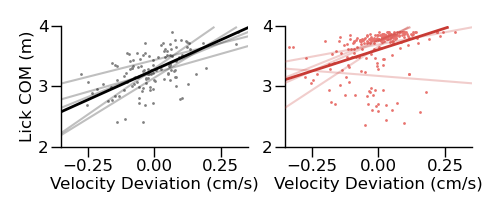

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(2.65, .8), dpi=200)
ax1, ax2 = axes
xlim = [-.35, .35]
ylim = [2, 4]

for mouse_num in range(1, 6):
    ax1.scatter(avg_vel_deviations_mice_days[mouse_num-1, 0],
                licking_com_mice_days[mouse_num-1, 0], c=style.day_0_color_light,
                s=1, lw=0, zorder=0)
    ax2.scatter(avg_vel_deviations_mice_days[mouse_num-1, 4],
                licking_com_mice_days[mouse_num-1, 4], c=style.day_4_color_light,
                s=1, lw=0, zorder=0)
    plotting_util.plot_linregress_result(ax1, linregress_results_mice_days[mouse_num-1, 0],
                                         xlim, ylim, c=style.day_0_color, **style.line_style,
                                         alpha=.25, zorder=100)
    plotting_util.plot_linregress_result(ax2, linregress_results_mice_days[mouse_num-1, 4],
                                         xlim, ylim, c=style.day_4_color, **style.line_style,
                                         alpha=.25, zorder=100)
    
linregress_results_days = linregress_results_mice_days.mean(axis=0)
plotting_util.plot_linregress_result(ax1, linregress_results_days[0], xlim, ylim, c=style.day_0_color, lw=1.)
plotting_util.plot_linregress_result(ax2, linregress_results_days[4], xlim, ylim, c=style.day_4_color, lw=1.)

ax1.set_ylabel("Lick COM (m)", **style.label_style)
for ax in axes:
    ax.set_xlabel("Velocity Deviation (cm/s)", **style.label_style)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plotting_util.prettyify_ax(ax)

plt.savefig(FIG_DIR + "lick_com_vs_velocity_deviation.svg", bbox_inches="tight")

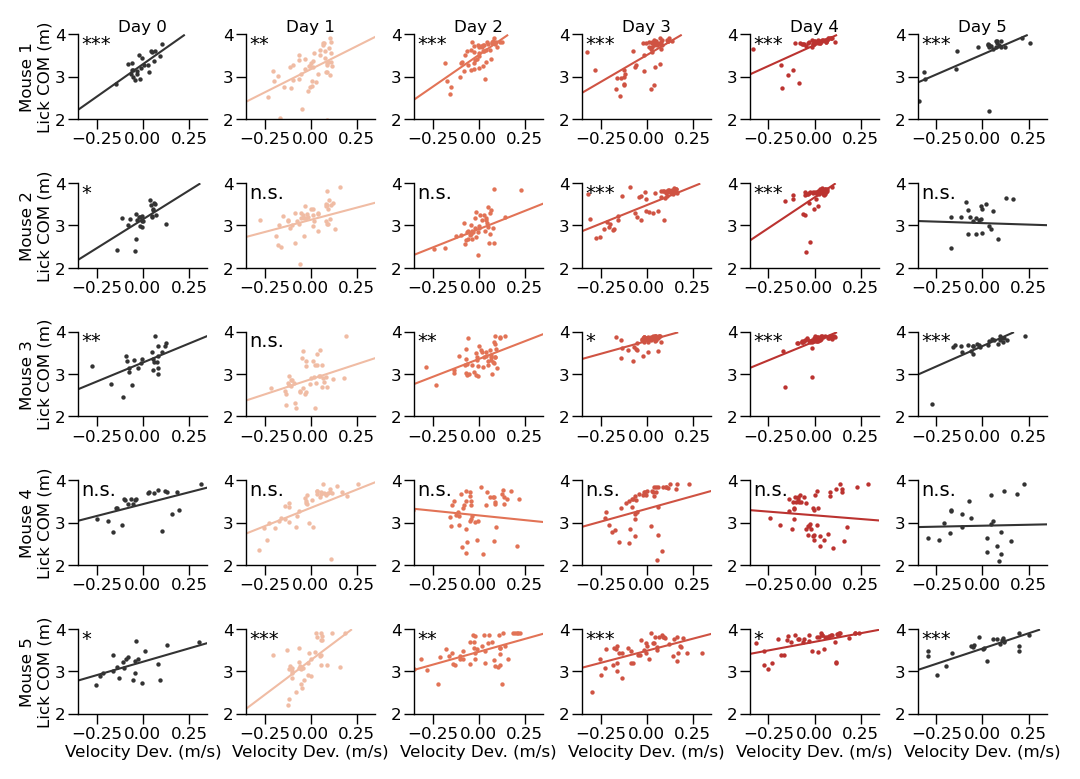

In [8]:
fig, axes = plt.subplots(5, 6, figsize=(6.25, 4.5), dpi=200)
fig.subplots_adjust(hspace=.75, wspace=.3)

xlim = [-.35, .35]
ylim = [2, 4]
for mouse_num in range(1, 6):
    for day_num in range(6):
        ax = axes[mouse_num-1, day_num]
        lr = linregress_results_mice_days[mouse_num-1, day_num]
        ax.scatter(avg_vel_deviations_mice_days[mouse_num-1, day_num],
                   licking_com_mice_days[mouse_num-1, day_num],
                   c=style.day_colors[day_num], **style.scatter_style)
        plotting_util.plot_linregress_result(ax, lr, xlim, ylim,
                                             c=style.day_colors[day_num], **style.line_style)
        if mouse_num == 1:
            ax.set_title("Day "+str(day_num), **style.title_style)
        if mouse_num == 5:
            ax.set_xlabel("Velocity Dev. (m/s)", **style.label_style)
        if day_num == 0:
            ax.set_ylabel("Mouse " + str(mouse_num) + "\nLick COM (m)", **style.label_style)
        p_str = plotting_util.get_p_str(slope_p_vals[mouse_num-1, day_num]*30) #Correct for multiple comparisons!
        ax.text(.025, 1., p_str, size=7, transform=ax.transAxes, ha="left", va="top")

for ax in axes.flatten():
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plotting_util.prettyify_ax(ax)
    
plt.savefig(FIG_DIR + "indiv_mouse_lick_com_vs_velocity_deviation.svg", bbox_inches="tight")